In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import math
import seaborn as sns
from matplotlib import cm
import os 
#plt.rc('font', size=22)

#https://jakevdp.github.io/PythonDataScienceHandbook/04.11-settings-and-stylesheets.html

from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
matplotlib.rcParams['text.color'] = 'gray'

#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})

#csvs = ['ccj-alpha_1..12.csv',
#'rv-counter_1..12.csv',
#'ccj-beta-prime_1..12.csv',
#'tv-uu_1..12.csv',
#'kr-n_1..4.csv',
#'pps-arbiter-standard_1..4.csv']

csvs = [
    'ba-known.ltl.csv', 'misc.csv',
'ba-new-fair2.ltl.neg.csv', 'pps-arbiter-standard_1..4.csv',
'ba-new-fair2.ltl.pos.csv', 'rv-counter_1..12.csv',
'ba-new.ltl.neg.csv', 'tgba-known.ltl.csv',
'ba-new.ltl.pos.csv', 'tgba-new-fair2.ltl.neg.csv',
'ba-new-strong1.ltl.neg.csv', 'tgba-new-fair2.ltl.pos.csv',
'ba-new-strong1.ltl.pos.csv', 'tgba-new.ltl.neg.csv',
'ba-new-strong2.ltl.neg.csv', 'tgba-new.ltl.pos.csv',
'ba-new-strong2.ltl.pos.csv', 'tgba-new-strong1.ltl.neg.csv',
'ba-new-weak3.ltl.neg.csv', 'tgba-new-strong1.ltl.pos.csv',
'ba-new-weak3.ltl.pos.csv', 'tgba-new-strong2.ltl.neg.csv',
'ccj-alpha_1..12.csv', 'tgba-new-strong2.ltl.pos.csv',
'ccj-beta-prime_1..12.csv', 'tgba-new-weak3.ltl.neg.csv',
'kr-n_1..4.csv', 'tgba-new-weak3.ltl.pos.csv',
'tv-uu_1..12.csv'
]

!echo results-*

results-00 results-01


In [2]:
csvs

['ccj-alpha_1..12.csv',
 'rv-counter_1..12.csv',
 'ccj-beta-prime_1..12.csv',
 'tv-uu_1..12.csv',
 'kr-n_1..4.csv',
 'pps-arbiter-standard_1..4.csv']

In [6]:
def load_bench(path):
    df = pd.read_csv(path, comment='#')
    df.dropna(axis=1, how='all', inplace=True)
    df.drop('time_unit', axis=1, inplace=True)
    df['deg'] = df['edges'] / df['states']
    return df

def show_bench(bench, ax, nb_bench=4, x='edges', name=None, version=''):
    nb_aut = len(bench) // nb_bench

    time_unit = 'ns'
    factor = 1
    
    med = bench['real_time'].mean()
    print(med)
    if med > 10**9:
        time_unit = 's'
        factor = 10**-9
    elif med > 10**6:
        time_unit = 'µs'
        factor = 10**-6
    
    for i in range(nb_bench):
        begin = i*nb_aut

        if name != None and name != bench['name'][begin][:-2]:
            continue

        end = (i+1)*nb_aut
        ax.plot(bench[begin:end][x], bench[begin:end]['real_time'] * factor, "-o", label=version + bench['name'][begin][:-2])
        
    ax.set_xlabel(x)
    ax.set_ylabel('time (' + time_unit + ')')
 
        
def show_speedup(bench, ax,  nb_bench=4, x='edges', version=''):
    nb_aut = len(bench) // nb_bench

    ax.plot(bench[:nb_aut][x], np.ones((nb_aut)))
    ref = bench[:nb_aut].real_time.values
    
    for i in range(1, nb_bench):
        begin = i*nb_aut
        end = (i+1)*nb_aut
                
        ax.plot(bench[begin:end][x], ref / bench[begin:end]['real_time'], "-o", label=version + bench['name'][begin][:-2])
    
    ax.set_xlabel(x)
    ax.set_ylabel('speed up')

    
    
def show_bests(bench, ax, algos=['sim', 'simPar1', 'simPar4', 'simPar8'], nb_bench=4):
    nb_aut = len(bench) // nb_bench

    n_algos = nb_bench
    bests = np.zeros((n_algos, n_algos))

    for i in range(n_algos):
        for j in range(n_algos):
            bench1 = bench[i::nb_bench]
            bench2 = bench[j::nb_bench]

            bests[i,j] = (bench1['real_time'].values > bench2['real_time'].values).sum()

    bests = bests / bests.sum()
    ax.imshow(bests, cmap='gray')
    
    title = 'bests:\n'
    for i in range(len(algos)):
        title += algos[i] + ' -> ' + str(i) + ', '
    ax.title.set_text(title)

def last():
    return sorted(glob.glob('results-*'))[-1]
    
def report(path, type='speed_up', algo1='sim', algo2='simPar8', nb_bench=4, x='edges'):
    bench_csv = glob.glob(path + '/*.{}'.format('csv'))
    
    nb_bench_x = 2
    nb_bench_y = (len(bench_csv) - 1) // nb_bench_x

    (fig, axes) = plt.subplots(nb_bench_x, nb_bench_y, figsize=(30, 15))
    axes = axes.flatten()
    i = 0
    for f in bench_csv:
        if f[-8:] == 'misc.csv' or f[-7:] == 'tmp.csv':
            continue

        bench = load_bench(f)

        if type == 'speed_up':
            show_speedup(bench, axes[i], nb_bench, x)
        else:
            show_bench(bench, axes[i], nb_bench, x)

        axes[i].title.set_text(f)
        i += 1

    plt.legend()

    (fig, axes) = plt.subplots(1, 2, figsize=(10, 5))
    bench = load_bench(path + '/misc.csv')

    show_bests(bench, axes[0])
    plt.title('misc: bests')
    
    #show_vs(bench, axes[1], algo2, algo1)
    #plt.title('misc: ' + algo1 + ' vs ' + algo2)

    plt.show()

1775032485.6506252
184118.09562500002
3059834760.8022914
201694.70708333337
570161590.3558333
1160049.6712500001


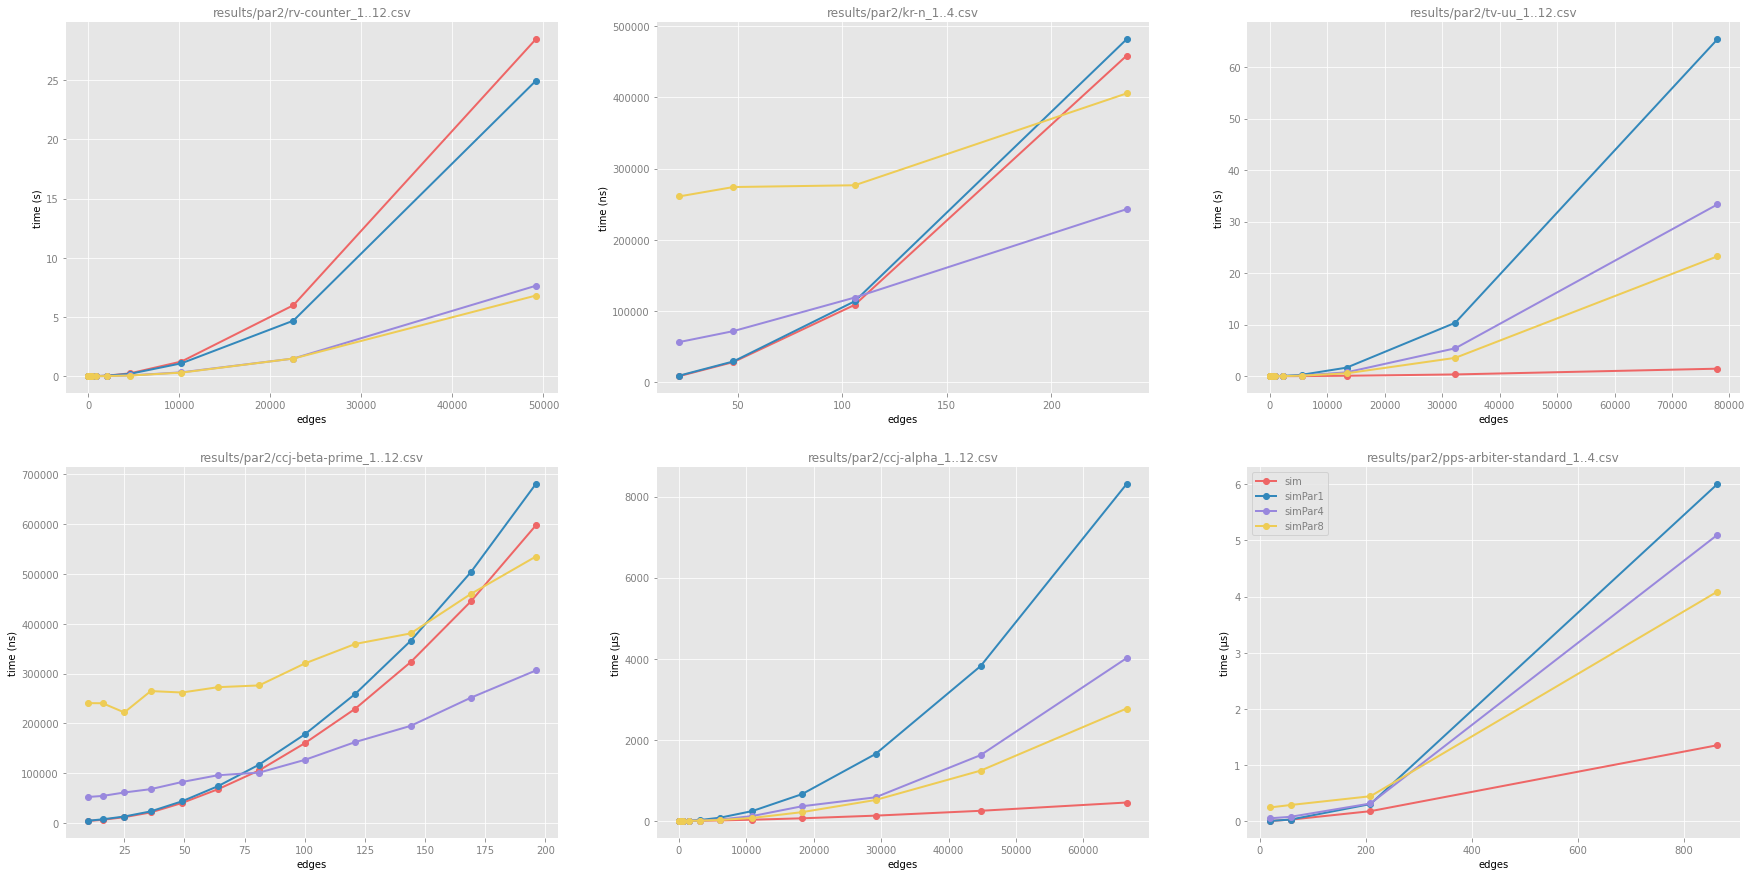

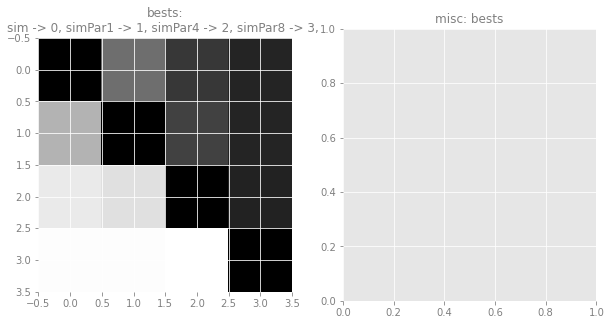

In [5]:
report('results/par2', type='time', algo1='simPar1', algo2='simPar8')

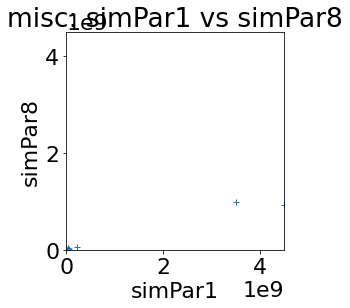

In [42]:
bench = load_bench('results/par4/misc.csv')

def show_vs(bench, ax, algo1, algo2, lim=None, nb_bench=4):
    bench1 = bench[bench['name'].str.match(algo1 + '//*')]
    bench2 = bench[bench['name'].str.match(algo2 + '//*')]

    if (len(bench1) == 0):
        raise ValueError('No bench named ' + algo1)
    if (len(bench2) == 0):
        raise ValueError('No bench named ' + algo2)

    lim = max(bench1['real_time'].max(), bench2['real_time'].max())
    
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    ax.set_aspect('equal', adjustable='box')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
        
    ax.set_xlabel(algo1)
    ax.set_ylabel(algo2)

    #plt.plot([0, lim], [0, lim])
    plt.plot(bench1['real_time'], bench2['real_time'], '+')

show_vs(bench, plt.gca(), 'simPar1', 'simPar8')
plt.title('misc: ' + 'simPar1' + ' vs ' + 'simPar8')
plt.show()

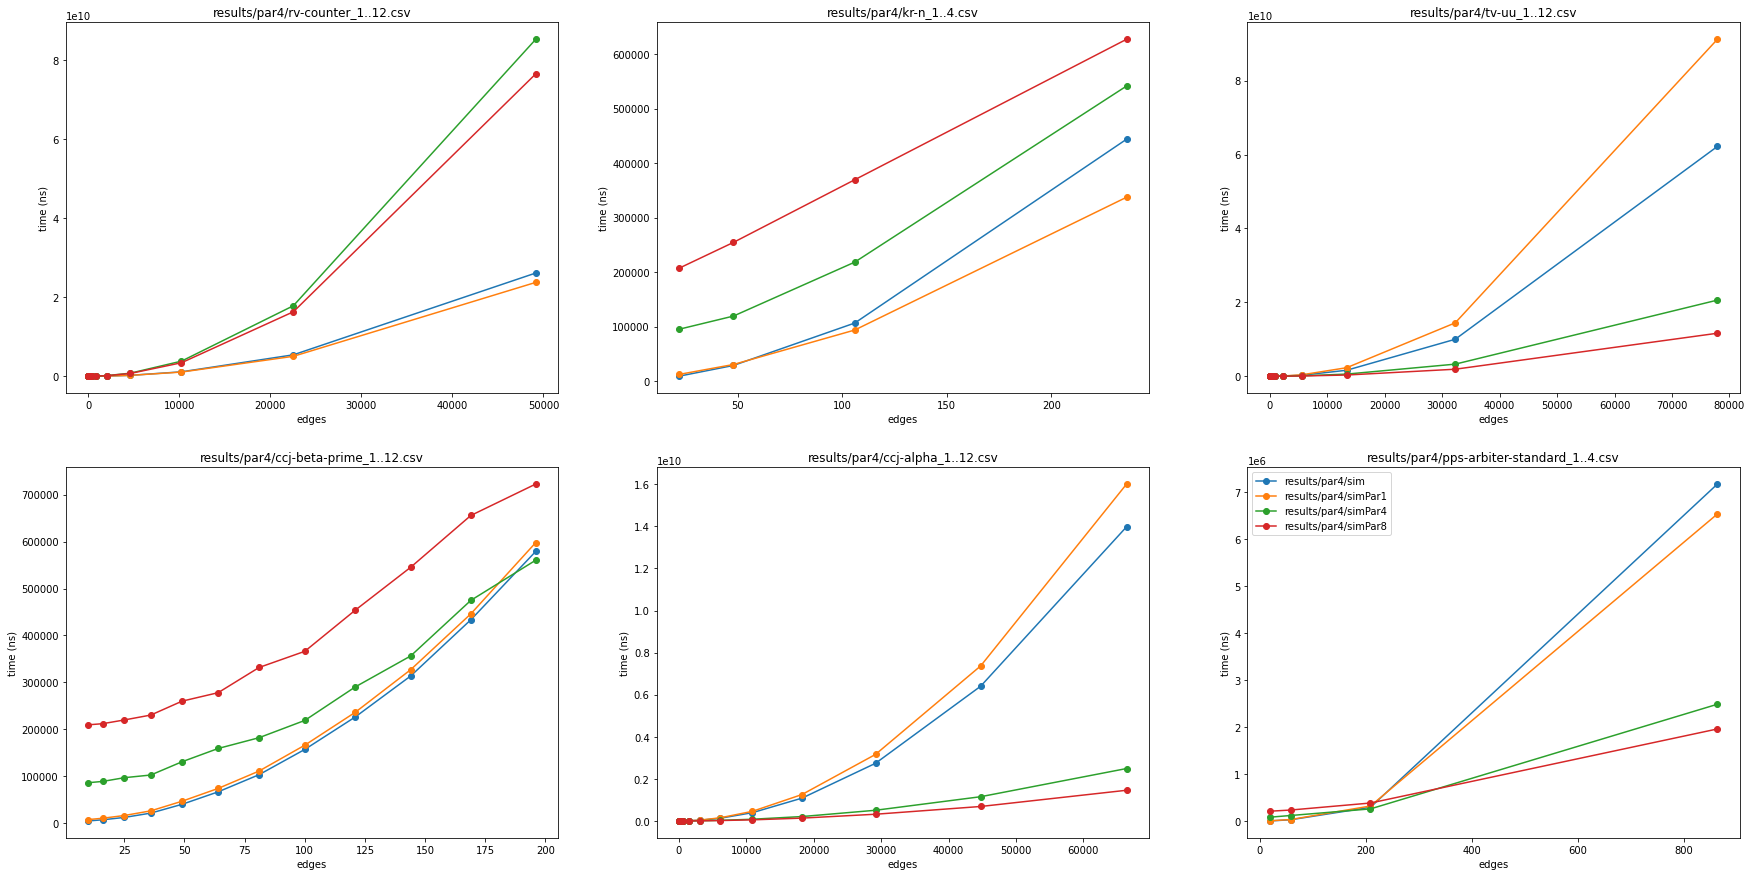

In [5]:
def compare(benchs, type='speed_up',  nb_bench=4, x='edges'):
    
    bench_csv = glob.glob(benchs[0] + '/*.{}'.format('csv'))
    
    nb_bench_x = 2
    nb_bench_y = (len(bench_csv) - 1) // nb_bench_x

    (fig, axes) = plt.subplots(nb_bench_x, nb_bench_y, figsize=(30, 15))
    axes = axes.flatten()
    
    for path in benchs:
        i = 0
        bench_csv = glob.glob(path + '/*.{}'.format('csv'))
        
        for f in bench_csv:
            if f[-8:] == 'misc.csv' or f[-7:] == 'tmp.csv':
                continue
                
            bench = load_bench(f)

            if type == 'speed_up':
                show_speedup(bench, axes[i], nb_bench, x, path)
            else:
                show_bench(bench, axes[i], nb_bench, x, path)

            axes[i].title.set_text(f)
            i += 1

    plt.legend()

compare(['results/par4/', 'results-04/'], type='time')

In [6]:
ls

all     bench*  decompose.cc     Makefile   results/     sim2  tests*
a.out*  data/   execute_all.sh*  README.md  results-00/  src/  visu_bench.ipynb


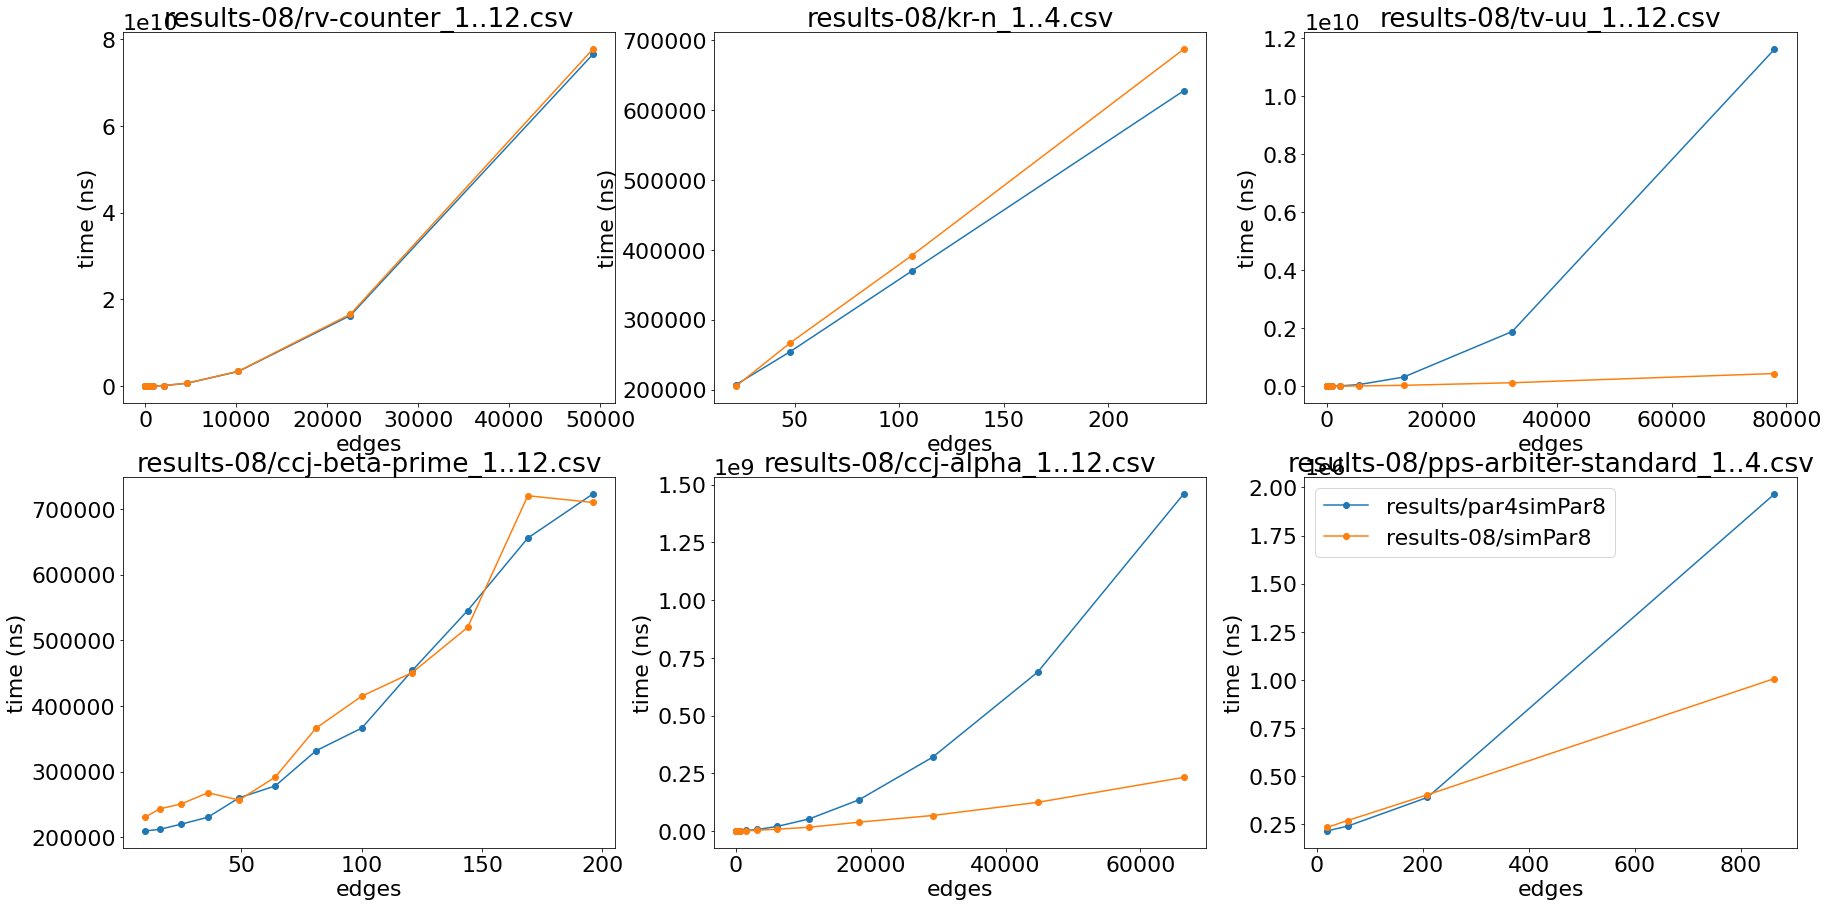

In [5]:
nb_bench=4
x='edges'
name='simPar8'
type='time'#'speed_up'

bench_path = 'results/par4'
bench_csv = glob.glob(bench_path + '/*.{}'.format('csv'))

nb_bench_x = 2
nb_bench_y = (len(bench_csv) - 1) // nb_bench_x

(fig, axes) = plt.subplots(nb_bench_x, nb_bench_y, figsize=(30, 15))
axes = axes.flatten()

i = 0
for f in bench_csv:
    if f[-8:] == 'misc.csv' or f[-7:] == 'tmp.csv':
        continue

    bench = load_bench(f)

    if type == 'speed_up':
        show_speedup(bench, axes[i], nb_bench, x)
    else:
        show_bench(bench, axes[i], nb_bench, x, name=name, version=bench_path)

    axes[i].title.set_text(f)
    i += 1

bench2_path = last() + '/'
bench_csv = glob.glob(bench2_path + '/*.{}'.format('csv'))
i = 0
for f in bench_csv:
    if f[-8:] == 'misc.csv' or f[-7:] == 'tmp.csv':
        continue

    bench = load_bench(f)

    if type == 'speed_up':
        show_speedup(bench, axes[i], nb_bench, x)
    else:
        show_bench(bench, axes[i], nb_bench, x, name=name, version=bench2_path)

    axes[i].title.set_text(f)
    i += 1

plt.legend()
plt.savefig('histogram.pgf')

In [6]:
! ls results/par4/

ccj-alpha_1..12.csv	  log.txt			 rv-counter_1..12.csv
ccj-beta-prime_1..12.csv  misc.csv			 tv-uu_1..12.csv
kr-n_1..4.csv		  pps-arbiter-standard_1..4.csv


In [37]:
def show_arrow(bench1, bench2, name1='', name2=''):
    plt.plot(bench1['edges'], bench1['real_time'], label=name1)
    plt.plot(bench2['edges'], bench2['real_time'], label=name2)

    x = bench2['edges'].values[-1]
    start_y = bench1['real_time'].values[-1]
    end_y = bench2['real_time'].values[-1]

    start = (x, start_y)
    end = (x, end_y)

    plt.annotate('', start, end, arrowprops=dict(arrowstyle='->'))
    plt.text(x * 0.80, (start_y + end_y) / 2, 'x ' + str(math.floor(start_y / end_y)))

    plt.gca().set_xlabel('edges')
    plt.gca().set_ylabel('time (ns)')

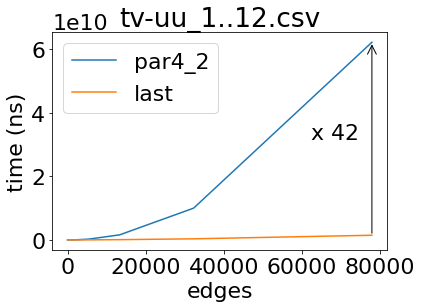

In [183]:
b = csvs[3]

old = load_bench('results/par4/' + b)
new = load_bench('results/par4_2/' + '/' + b)

n = len(old) // 4

show_arrow(old[:n], new[:n], 'par4_2', 'last')

plt.title(b)
plt.legend()
plt.show()

In [151]:
old

name  iterations     real_time      cpu_time  edges  red_edges  \
0        sim/0      258586  2.713890e+03  2.712830e+03      2          2   
1        sim/1      164433  4.244120e+03  4.242170e+03      8          8   
2        sim/2       57284  1.227850e+04  1.227240e+04     24         24   
3        sim/3       12035  5.945230e+04  5.937250e+04     65         64   
4        sim/4        2402  2.913160e+05  2.911590e+05    162        160   
5        sim/5         437  1.610130e+06  1.609140e+06    387        385   
6        sim/6          78  9.010610e+06  9.005610e+06    900        898   
7        sim/7          15  4.819060e+07  4.817010e+07   2053       2051   
8        sim/8           3  2.537490e+08  2.536180e+08   4614       4612   
9        sim/9           1  1.320620e+09  1.319730e+09  10247      10245   
10      sim/10           1  6.435080e+09  6.430980e+09  22536      22534   
11      sim/11           1  3.014230e+10  3.012430e+10  49161      49159   
12   simPar1/0      132851  5.239630e+03  5.237510e+03      2          2   
13   simPar1/1       96291  7.254540e+03  7.250820e+03      8          8   
14   simPar1/2       40390  1.728600e+04  1.727870e+04     24         24   
15   simPar1/3       10082  6.938230e+04  6.934720e+04     65         64   
16   simPar1/4        2211  3.167610e+05  3.166030e+05    162        160   
17   simPar1/5         435  1.614570e+06  1.613580e+06    387        385   
18   simPar1/6          84  8.354710e+06  8.349810e+06    900        898   
19   simPar1/7          16  4.328790e+07  4.326780e+07   2053       2051   
20   simPar1/8           3  2.135270e+08  2.134110e+08   4614       4612   
21   simPar1/9           1  1.078330e+09  1.077810e+09  10247      10245   
22  simPar1/10           1  5.197520e+09  5.194640e+09  22536      22534   
23  simPar1/11           1  2.476180e+10  2.474760e+10  49161      49159   
24   simPar4/0        9549  8.478180e+04  7.214500e+04      2          2   
25   simPar4/1        9457  8.542940e+04  7.339910e+04      8          8   
26   simPar4/2        7004  1.134520e+05  1.022660e+05     24         24   
27   simPar4/3        2751  2.643300e+05  2.540620e+05     65         64   
28   simPar4/4         653  1.083910e+06  1.074490e+06    162        160   
29   simPar4/5         134  5.234880e+06  5.221680e+06    387        385   
30   simPar4/6          27  2.654080e+07  2.650980e+07    900        898   
31   simPar4/7           5  1.331630e+08  1.330800e+08   2053       2051   
32   simPar4/8           1  6.708340e+08  6.703770e+08   4614       4612   
33   simPar4/9           1  3.496690e+09  3.494530e+09  10247      10245   
34  simPar4/10           1  1.775910e+10  1.773940e+10  22536      22534   
35  simPar4/11           1  8.315070e+10  8.302470e+10  49161      49159   
36   simPar8/0        3713  2.071740e+05  1.841970e+05      2          2   
37   simPar8/1        4089  2.039890e+05  1.803340e+05      8          8   
38   simPar8/2        3312  2.374330e+05  2.153890e+05     24         24   
39   simPar8/3        1678  4.266210e+05  3.939540e+05     65         64   
40   simPar8/4         572  1.273110e+06  1.225550e+06    162        160   
41   simPar8/5         123  5.793190e+06  5.641720e+06    387        385   
42   simPar8/6          25  2.882580e+07  2.769790e+07    900        898   
43   simPar8/7           5  1.384250e+08  1.325340e+08   2053       2051   
44   simPar8/8           1  6.949190e+08  6.510590e+08   4614       4612   
45   simPar8/9           1  3.501910e+09  2.797340e+09  10247      10245   
46  simPar8/10           1  1.658350e+10  1.623800e+10  22536      22534   
47  simPar8/11           1  7.652650e+10  5.476750e+10  49161      49159   

    red_states  states  deg  
0            2       2  1.0  
1            8       8  1.0  
2           24      24  1.0  
3           64      65  1.0  
4          160     162  1.0  
5          385     387  1.0  
6          898     900  1.0  
7         2051    2053  1.0  
8         4612 

In [143]:
new

name  iterations  real_time   cpu_time  edges  red_edges  red_states  \
0       sim/0       74639    9043.05    9038.93     22         17          10   
1       sim/1       22512   30698.00   30683.50     48         43          25   
2       sim/2        5907  119953.00  119879.00    106        101          58   
3       sim/3        1423  488256.00  488011.00    236        231         131   
4   simPar1/0       57102   12219.40   12213.70     22         17          10   
5   simPar1/1       22892   30414.90   30400.50     48         43          25   
6   simPar1/2        7402   94220.50   94174.80    106        101          58   
7   simPar1/3        2065  341915.00  341705.00    236        231         131   
8   simPar4/0        8156   92751.70   79722.00     22         17          10   
9   simPar4/1        6555  123417.00  110608.00     48         43          25   
10  simPar4/2        3297  220382.00  207330.00    106        101          58   
11  simPar4/3        1390  520955.00  511430.00    236        231         131   
12  simPar8/0        3800  220708.00  196698.00     22         17          10   
13  simPar8/1        3232  247963.00  224917.00     48         43          25   
14  simPar8/2        2176  370943.00  341135.00    106        101          58   
15  simPar8/3        1093  682768.00  646352.00    236        231         131   

    states       deg  
0       13  1.692308  
1       28  1.714286  
2       61  1.737705  
3      134  1.761194  
4       13  1.692308  
5       28  1.714286  
6       61  1.737705  
7      134  1.761194  
8       13  1.692308  
9       28  1.714286  
10      61  1.737705  
11     134  1.761194  
12      13  1.692308  
13      28  1.714286  
14      61  1.737705  
15     134  1.761194

1258370118.4014585


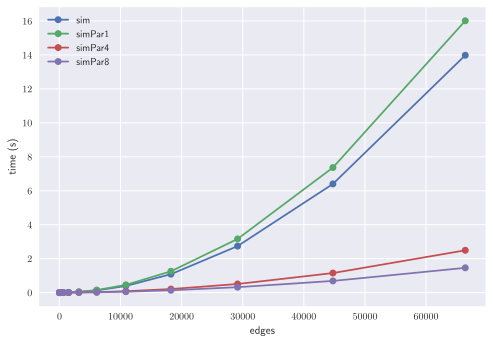

In [52]:
with plt.style.context('seaborn'):
    bench = load_bench('results/par4/ccj-alpha_1..12.csv')
    show_bench(bench, plt.gca())
    plt.legend()
    #plt.show()
    plt.savefig('par4_ccj.pgf')

In [15]:
def load_all(path):
    first = True
    all_bench = None

    for csv in csvs:
        tmp = load_bench(path + '/' + csv)
        tmp['source'] = 'genltl/' + csv[:-4]

        if first:
            all_bench = tmp
            first = False
        else:
            all_bench = all_bench.append(tmp)

    tmp = load_bench(path + '/misc.csv')
    tmp['source'] = 'rabbit + circuits'
    all_bench = all_bench.append(tmp)

    return all_bench

def show_vs(bench, ax, algo1, algo2, lim=None, nb_bench=4):
    bench1 = bench[bench['name'].str.match(algo1)]
    bench2 = bench[bench['name'].str.match(algo2)]

    if (len(bench1) == 0):
        raise ValueError('No bench named ' + algo1)
    if (len(bench2) == 0):
        raise ValueError('No bench named ' + algo2)

    lim = max(bench1['real_time'].max(), bench2['real_time'].max())
    
    ax.set_aspect('equal', adjustable='box')
    ax.set_xscale('log')
    ax.set_yscale('log')
        
    ax.set_xlabel(algo1)
    ax.set_ylabel(algo2)

    cmap = matplotlib.cm.get_cmap('Set3')    

    i = 0
    for k,d in bench1.groupby('source'):
        b1 = bench1[bench1['source'] == k]
        b2 = bench2[bench2['source'] == k]
        plt.scatter(b1['real_time'], b2['real_time'], marker='.', color=cmap(i), label=k)
        i += 1
    m = bench1['real_time'].max()
    plt.plot([0, m], [0, m], c='gray', linewidth=0.7)
    plt.plot([0, m], [0, m/10], c='lightgray', linewidth=0.7)
    plt.plot([0, m/10], [0, m], c='lightgray', linewidth=0.7)

nb_thread = 'simPar1//*'

path1 = 'results/par4/'
name1 = 'par41'

path2 = 'results-09/'
name2 = 'par42'

big_par4 = load_all(path1)
big_par4 = big_par4[big_par4['name'].str.match(nb_thread)]
big_par4['name'] = name1

big_par4_2 = load_all(path2)
big_par4_2 = big_par4_2[big_par4_2['name'].str.match(nb_thread)]
big_par4_2['name'] = name2

big = big_par4.append(big_par4_2)

with plt.style.context('seaborn'):
    show_vs(big, plt.gca(), name1, name2, nb_bench=1)
    plt.legend()    
    plt.savefig('vs.pgf')

FileNotFoundError: [Errno 2] No such file or directory: 'results/par4//ba-known.ltl.csv'

5576867525.949375


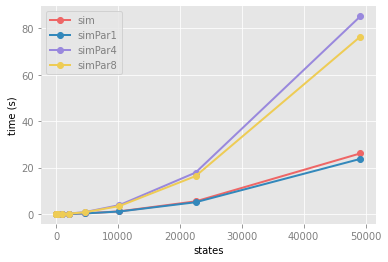

In [9]:
show_bench(load_bench('results/par4/rv-counter_1..12.csv'), plt.gca(), x='states')
plt.legend()

1127087748.7006252


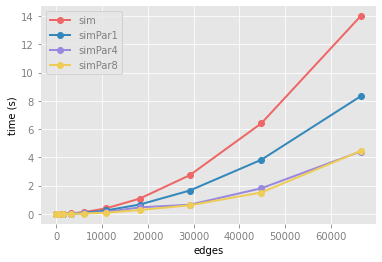

In [13]:
par2 = load_bench('results/par2_1/ccj-alpha_1..12.csv')
par4 = load_bench('results/par4/ccj-alpha_1..12.csv')

par2[par2['name'].str.match('sim//*')] = par4[par4['name'].str.match('sim//*')]
show_bench(par2, plt.gca())
plt.legend()

In [127]:
last()

'results-12'

5709499432.1727085
28.4961 77.9843 49161


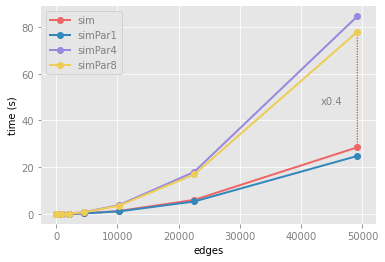

In [146]:
b = load_bench('results/par4_2/rv-counter_1..12.csv')
show_bench(b, plt.gca())

start_y = b[b['name'].str.match('simPar8//*')]['real_time'].max() / 10**9
end_y = b[b['name'].str.match('sim//*')]['real_time'].max() / 10**9

x = b['edges'].max()
print(end_y, start_y, x)

l = 'x' + str(round(end_y / start_y, 1))

plt.arrow(x, start_y, 0, end_y - start_y - 0.3, color="chocolate", ls=':', length_includes_head=True, head_width=1000, head_length=1)
plt.text(x - 6000, start_y + (end_y - start_y) / 1.6, l)

plt.legend()

5174040515.843959


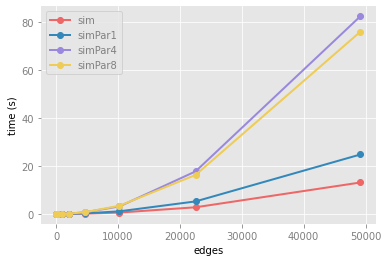

In [141]:
b = load_bench('results-00/rv-counter_1..12.csv')
show_bench(b, plt.gca())
plt.legend()

In [3]:
ls

1_aut.hoa          perf.data.old  results-05/  results-15/  sim2
all                plot.py*       results-06/  results-16/  src/
bab_vs_rabbit.pgf  Rapport.ipynb  results-07/  results-17/  tests*
bench*             README.md      results-08/  results-18/  Untitled.ipynb
bench_babiak*      results/       results-09/  results-19/  visu_bench.ipynb
data/              results-00/    results-10/  results-20/  vs_bab.ipynb
decompose          results-01/    results-11/  results-21/
execute_all.sh*    results-02/    results-12/  results-22/
Makefile           results-03/    results-13/  results-23/
perf.data          results-04/    results-14/  results-24/


In [6]:
old = load_bench('results-23/ccj-alpha_1..12.csv')
new = load_bench('results-24/c')

In [10]:
np.sum(old['red_edges'] != new['red_edges'])

0

In [53]:
last()

'results-28'

In [6]:
b = load_bench('results-00/tv-uu_1..12.csv')

In [7]:
b

name  iterations     real_time      cpu_time  det  edges  red_det  \
0      sim/0       58201  1.188360e+04  1.188000e+04    2      4        1   
1      sim/1       42944  1.641530e+04  1.641070e+04    3      9        3   
2      sim/2       24241  2.863250e+04  2.862480e+04    5     23        5   
3      sim/3       11864  5.958550e+04  5.956460e+04    8     55        8   
4      sim/4        4192  1.668260e+05  1.667730e+05   13    134       13   
5      sim/5        1378  5.194160e+05  5.192220e+05   21    323       21   
6      sim/6         467  1.515890e+06  1.515190e+06   34    781       34   
7      sim/7         158  4.431500e+06  4.429490e+06   55   1885       55   
8   babiak/0       96322  7.361840e+03  7.359850e+03    2      4        0   
9   babiak/1       10000  5.007320e+04  5.005810e+04    3      9        2   
10  babiak/2        3631  1.899080e+05  1.898290e+05    5     23        5   
11  babiak/3         846  8.743200e+05  8.737050e+05    8     55        8   
12  babiak/4         181  3.799400e+06  3.797340e+06   13    134       13   
13  babiak/5          41  1.701970e+07  1.701100e+07   21    323       21   
14  babiak/6           7  1.013970e+08  1.013190e+08   34    781       34   
15  babiak/7           1  5.073210e+08  5.069030e+08   55   1885       55   

    red_edges  red_states  states        deg  
0           4           2       2   2.000000  
1           9           3       3   3.000000  
2          23           5       5   4.600000  
3          55           8       8   6.875000  
4         134          13      13  10.307692  
5         323          21      21  15.380952  
6         781          34      34  22.970588  
7        1885          55      55  34.272727  
8           4           2       2   2.000000  
9           9           3       3   3.000000  
10         23           5       5   4.600000  
11         55           8       8   6.875000  
12        134          13      13  10.307692  
13        323          21      21  15.380952  
14        781          34      34  22.970588  
15       1885          55      55  34.272727

In [11]:
(bab['det'].values < sim['det'].values).sum()

0

In [13]:
 ls results-00/

ba-known.ltl.csv            misc.csv
ba-new-fair2.ltl.neg.csv    pps-arbiter-standard_1..4.csv
ba-new-fair2.ltl.pos.csv    rv-counter_1..12.csv
ba-new.ltl.neg.csv          tgba-known.ltl.csv
ba-new.ltl.pos.csv          tgba-new-fair2.ltl.neg.csv
ba-new-strong1.ltl.neg.csv  tgba-new-fair2.ltl.pos.csv
ba-new-strong1.ltl.pos.csv  tgba-new.ltl.neg.csv
ba-new-strong2.ltl.neg.csv  tgba-new.ltl.pos.csv
ba-new-strong2.ltl.pos.csv  tgba-new-strong1.ltl.neg.csv
ba-new-weak3.ltl.neg.csv    tgba-new-strong1.ltl.pos.csv
ba-new-weak3.ltl.pos.csv    tgba-new-strong2.ltl.neg.csv
ccj-alpha_1..12.csv         tgba-new-strong2.ltl.pos.csv
ccj-beta-prime_1..12.csv    tgba-new-weak3.ltl.neg.csv
kr-n_1..4.csv               tgba-new-weak3.ltl.pos.csv
log.txt                     tv-uu_1..12.csv


In [23]:
def stat(path, version):
    b = load_bench(path)
    
    sim = b[b['name'].str.match('sim//*')]
    bab = b[b['name'].str.match('babiak//*')]
    
    print('total', len(sim))
    print('bab better', (bab['red_det'].values < sim['red_det'].values).sum())
    print('sim better', (bab['red_det'].values > sim['red_det'].values).sum())
    print('')

import sys

for p in os.listdir('results-00/'):
    if p[-4:] != '.csv':
        continue
        
    print(p)
    stat('results-00/' + p)

ba-new-strong2.ltl.neg.csv
total 100
bab better 35
sim better 1

ba-new-fair2.ltl.neg.csv
total 100
bab better 32
sim better 1

pps-arbiter-standard_1..4.csv
total 4
bab better 0
sim better 0

tgba-new.ltl.neg.csv
total 100
bab better 36
sim better 1

ba-new-strong2.ltl.pos.csv
total 90
bab better 14
sim better 1

ba-new-weak3.ltl.pos.csv
total 100
bab better 26
sim better 1

kr-n_1..4.csv
total 4
bab better 0
sim better 0

tgba-new-fair2.ltl.pos.csv
total 100
bab better 27
sim better 1

tgba-new-strong1.ltl.neg.csv
total 100
bab better 35
sim better 1

tgba-known.ltl.csv
total 184
bab better 56
sim better 1

ba-new-strong1.ltl.neg.csv
total 100
bab better 35
sim better 1

tgba-new-weak3.ltl.pos.csv
total 100
bab better 26
sim better 1

tgba-new-strong2.ltl.pos.csv
total 90
bab better 14
sim better 1

ba-known.ltl.csv
total 184
bab better 56
sim better 1

tgba-new-weak3.ltl.neg.csv
total 100
bab better 33
sim better 1

ccj-alpha_1..12.csv
total 7
bab better 7
sim better 0

tgba-new-str

In [24]:
for p in os.listdir('results-01/'):
    if p[-4:] != '.csv':
        continue
        
    print(p)
    stat('results-01/' + p)

ba-new-strong2.ltl.neg.csv
total 100
bab better 97
sim better 0

ba-new-fair2.ltl.neg.csv
total 100
bab better 59
sim better 7

pps-arbiter-standard_1..4.csv
total 4
bab better 0
sim better 0

tgba-new.ltl.neg.csv
total 100
bab better 64
sim better 2

ba-new-strong2.ltl.pos.csv
total 90
bab better 90
sim better 0

ba-new-weak3.ltl.pos.csv
total 100
bab better 100
sim better 0

kr-n_1..4.csv
total 4
bab better 0
sim better 0

tgba-new-fair2.ltl.pos.csv
total 100
bab better 100
sim better 0

tgba-new-strong1.ltl.neg.csv
total 100
bab better 93
sim better 3

tgba-known.ltl.csv
total 184
bab better 101
sim better 0

ba-new-strong1.ltl.neg.csv
total 100
bab better 93
sim better 3

tgba-new-weak3.ltl.pos.csv
total 100
bab better 100
sim better 0

tgba-new-strong2.ltl.pos.csv
total 90
bab better 90
sim better 0

ba-known.ltl.csv
total 184
bab better 101
sim better 0

tgba-new-weak3.ltl.neg.csv
total 100
bab better 59
sim better 7

ccj-alpha_1..12.csv
total 7
bab better 7
sim better 0

tgba-ne

In [35]:
load_bench('results-00/ba-known.ltl.csv')

name  iterations  real_time   cpu_time  det  edges  red_det  \
0         sim/0      152610    4608.64    4606.86    0      1        0   
1         sim/1      121329    5907.24    5904.48    0      3        0   
2         sim/2       43954   15420.00   15415.40    1      7        1   
3         sim/3       88861    7893.44    7891.15    1      5        0   
4         sim/4       61592   11598.60   11595.30    1      3        1   
..          ...         ...        ...        ...  ...    ...      ...   
363  babiak/179        3568  198010.00  197708.00    1     11        1   
364  babiak/180       62479   11039.60   11025.90    0      2        0   
365  babiak/181      104605    7119.66    7109.16    0      2        0   
366  babiak/182        8248   82728.90   82560.80    2      9        2   
367  babiak/183        2526  334461.00  333641.00    3     26        2   

     red_edges  red_states  states       deg  
0            1           1       1  1.000000  
1            3           2       2  1.500000  
2            7           4       4  1.750000  
3            5           3       3  1.666667  
4            3           2       2  1.500000  
..         ...         ...     ...       ...  
363         11           6       6  1.833333  
364          2           2       2  1.000000  
365          2           2       2  1.000000  
366          9           4       4  2.250000  
367         26           6       6  4.333333  

[368 rows x 11 columns]

    | Sim avant | Sim apres | Babiak | Original | Total
csv |

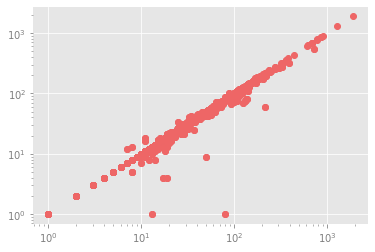

In [22]:
b = load_all('results-00')

sim = b[b['name'].str.match('sim//*')]
bab = b[b['name'].str.match('babiak//*')]

plt.xscale('log')
plt.yscale('log')

plt.scatter(sim['red_edges'], bab['red_edges'])

['ba-new-strong2.ltl.neg.csv',
 'ba-new-fair2.ltl.neg.csv',
 'pps-arbiter-standard_1..4.csv',
 'tgba-new.ltl.neg.csv',
 'ba-new-strong2.ltl.pos.csv',
 'ba-new-weak3.ltl.pos.csv',
 'kr-n_1..4.csv',
 'log.txt',
 'tgba-new-fair2.ltl.pos.csv',
 'tgba-new-strong1.ltl.neg.csv',
 'tgba-known.ltl.csv',
 'ba-new-strong1.ltl.neg.csv',
 'tgba-new-weak3.ltl.pos.csv',
 'tgba-new-strong2.ltl.pos.csv',
 'ba-known.ltl.csv',
 'tgba-new-weak3.ltl.neg.csv',
 'ccj-alpha_1..12.csv',
 'tgba-new-strong2.ltl.neg.csv',
 'ba-new.ltl.pos.csv',
 'tgba-new-fair2.ltl.neg.csv',
 'ba-new-weak3.ltl.neg.csv',
 'tv-uu_1..12.csv',
 'ba-new-strong1.ltl.pos.csv',
 'ba-new.ltl.neg.csv',
 'rv-counter_1..12.csv',
 'misc.csv',
 'ba-new-fair2.ltl.pos.csv',
 'ccj-beta-prime_1..12.csv',
 'tgba-new-strong1.ltl.pos.csv',
 'tgba-new.ltl.pos.csv']